In [1]:
import json
import pprint
from pathlib import Path
import sys
sys.path.insert(1, '../src')
sys.path.insert(1, '../src/utils')
import ipdb
import itertools
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.cluster import AffinityPropagation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

from preprocessing import Preprocessing
from config import Config 

import pickle

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Variables

In [4]:
num_topics = 15
use_title = True
# don't use stemming
stemming = False
lemmatization = True
# use nltk since it is a lot faster than spacy and the results are better with nltk
lib = "nltk"

input_path = Path("../src/data/data_jmlr_vol13-21.json")

# Data loading and preparation

## Load data

In [5]:
def load_data():
    with open(input_path, encoding="utf-8") as f:
        data = json.load(f)
    data_df = pd.json_normalize(data['papers'])
    corpus = data_df["abstract"]
    if use_title:
        corpus = data_df["title"] + " " + corpus 
    return corpus

corpus = load_data()

## Preprocessing

In [6]:
config = Config.from_file("config_notebook.yaml")
corpus = Preprocessing(
        corpus,
        config=config.preprocessing,
    ).apply_preprocessing()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
1261it [00:07, 179.93it/s]


### TD-IDF

In [7]:
vectorizer = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus =  vectorizer.fit_transform(corpus["token"])

# Clustering

In [8]:
tdidf_ap_clustering = AffinityPropagation(random_state=0)
tdidf_ap_clustering.fit(tfidf_corpus.toarray())

AffinityPropagation(random_state=0)

In [9]:
pickle.dump(tdidf_ap_clustering, open('ap_data/tdidf_ap_clustering', 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: 'ap_data/tdidf_ap_clustering'

In [10]:
def get_top_words(vectorizer, corpus):
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(corpus.sum(axis=0)).ravel())
    sorted_scores = list(zip(*sorted(scores, key=lambda x: x[1], reverse=True)))
    top_words = sorted_scores[0][:10]
    return top_words
    

def print_and_get_clusters(model, corpus):
    labels = model.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    if (n_clusters_ == 0):
        print('No clusters found')
        return
    
    clusters = []
    print("Top terms per cluster:")
    for i in range(n_clusters_):
        print("Cluster %d:" % i)
        vectorizer_terms = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
        tfidf_corpus_terms = vectorizer_terms.fit_transform(corpus.iloc[np.where(model.labels_ == i)]["token"])
        top_words = get_top_words(vectorizer_terms, tfidf_corpus_terms)
        print(top_words)
        clusters.append(top_words)
        print("\n")
        
    return clusters

In [11]:
clusters = print_and_get_clusters(tdidf_ap_clustering, corpus)

Top terms per cluster:
Cluster 0:
('preference', 'pairwise', 'model', 'ontology', 'learning', 'query', 'problem', 'label', 'aggregation', 'mallow')


Cluster 1:
('algorithm', 'selective', 'learning', 'setting', 'stream', 'classification', 'classifier', 'active', 'label', 'pool')


Cluster 2:
('metric', 'learning', 'distance', 'kernel', 'data', 'algorithm', 'ground', 'graph', 'matrix', 'method')


Cluster 3:
('model', 'selection', 'criterion', 'dimension', 'information', 'distribution', 'algorithm', 'feature', 'value', 'minimal')


Cluster 4:
('task', 'learning', 'transfer', 'problem', 'text', 'framework', 'skill', 'reinforcement', 'data', 'related')


Cluster 5:
('maximum', 'data', 'dimensionality', 'reduction', 'method', 'likelihood', 'analysis', 'linear', 'unfolding', 'approximate')


Cluster 6:
('variational', 'approximation', 'gaussian', 'model', 'inference', 'process', 'method', 'likelihood', 'algorithm', 'distribution')


Cluster 7:
('dimensional', 'coefficient', 'model', 'data',

('ranking', 'comparison', 'item', 'problem', 'data', 'seriation', 'bound', 'pairwise', 'algorithm', 'estimator')


Cluster 71:
('cascade', 'network', 'diffusion', 'model', 'algorithm', 'bound', 'node', 'influence', 'inference', 'time')


Cluster 72:
('domain', 'distribution', 'algorithm', 'target', 'adaptation', 'discrepancy', 'source', 'feature', 'sdas', 'data')


Cluster 73:
('signal', 'noise', 'latent', 'regression', 'model', 'accumulation', 'observation', 'memory', 'factor', 'data')


Cluster 74:
('dantzig', 'selector', 'sparse', 'factor', 'method', 'recovery', 'signal', 'approach', 'effect', 'exhibiting')


Cluster 75:
('control', 'learning', 'exploration', 'reinforcement', 'rl', 'problem', 'function', 'process', 'value', 'dynamic')


Cluster 76:
('matrix', 'covariance', 'estimator', 'sparse', 'model', 'estimation', 'method', 'data', 'algorithm', 'inverse')


Cluster 77:
('pca', 'thresholding', 'sparse', 'via', 'online', 'optimal', 'regret', 'covariance', 'data', 'consistency')




('matrix', 'completion', 'bound', 'algorithm', 'rank', 'norm', 'approach', 'low', 'error', 'structure')


Cluster 142:
('hmc', 'subsampling', 'data', 'method', 'step', 'metropolized', 'estimator', 'parameter', 'algorithm', 'carlo')


Cluster 143:
('pattern', 'attribute', 'latent', 'model', 'feature', 'temporal', 'bayes', 'naive', 'weighting', 'data')


Cluster 144:
('learning', 'concept', 'private', 'sample', 'privacy', 'time', 'algorithm', 'class', 'complexity', 'method')


Cluster 145:
('risk', 'score', 'method', 'algorithm', 'learning', 'prediction', 'breast', 'structed', 'task', 'structured')


Cluster 146:
('uncertainty', 'market', 'prediction', 'set', 'approach', 'function', 'statistical', 'artificial', 'quantifying', 'loss')


Cluster 147:
('function', 'communication', 'algorithm', 'optimization', 'network', 'decentralized', 'distributed', 'model', 'problem', 'learning')


Cluster 148:
('change', 'point', 'model', 'algorithm', 'system', 'data', 'graphical', 'penalty', 'surface',

# Visualization

In [12]:
def visualize_clustering_result_arr(model, X):
    cluster_centers_indices = model.cluster_centers_indices_
    labels = model.labels_

    n_clusters_ = len(cluster_centers_indices)

    print('Estimated number of clusters: %d' % n_clusters_)

    plt.close('all')
    plt.figure(1)
    plt.clf()

    colors = itertools.cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for k, col in zip(range(n_clusters_), colors):
        class_members = labels == k
        cluster_center = X[cluster_centers_indices[k]]
        plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
        plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=14)
        for x in X[class_members]:
            plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()


def visualize_clustering_result(model, corpus):
    X = corpus.toarray()
    visualize_clustering_result_arr(model, X)
   

Estimated number of clusters: 179


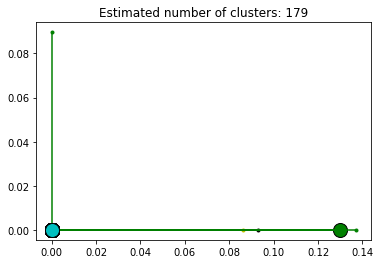

In [13]:
visualize_clustering_result(tdidf_ap_clustering, tfidf_corpus)

# Try different arguments for `AP`

damping: 0.5, max_iter: 200, convergence: 8, preference: -50
Estimated number of clusters: 1261


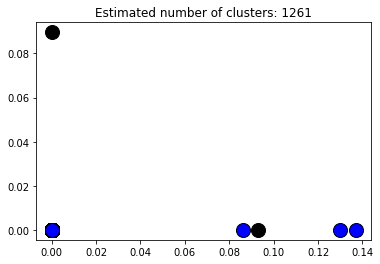

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('data', 'nearest', 'neighbor', 'set', 'global', 'high', 'hub', 'hubness', 'large', 'local')


Cluster 87:
('online', 'submodular', 'algorithm', 'computationally', 'consider', 'consistent', 'decision', 'discrete', 'efficient', 'feedback')


Cluster 88:
('problem', 'method', 'algorithm', 'ip', 'kernel', 'point', 'robust', 'saddle', 'svm', 'uncertainty')


Cluster 89:
('causal', 'effect', 'cit', 'facilitating', 'score', 'treatment', 'data', 'inference', 'also', 'estimating')


Cluster 90:
('oger', 'learning', 'architecture', 'data', 'large', 'modular', 'organic', 'processing', 'reservoir', 'sequential')


Cluster 91:
('bag', 'learning', 'mil', 'algorithm', 'instance', 'label', 'application', 'class', 'hypothesis', 'sample')


Cluster 92:
('policy', 'algorithm', 'bound', 'iteration', 'chain', 'derive', 'learning', 'least', 'markov', 'performance')


Cluster 93:
('hierarchical', 'part', 'human', 'model', 'action', 'based', 'body', 'parsing', 'pose', 'poselets')


Cluster 94:
('algorithm', 

('experiment', 'causal', 'discovery', 'result', 'selection', 'set', 'among', 'combinatorics', 'construction', 'criterion')


Cluster 163:
('network', 'learning', 'stationary', 'algorithm', 'high', 'problem', 'sparse', 'topology', 'berhu', 'bisps')


Cluster 164:
('algorithm', 'margin', 'learning', 'parallel', 'boosting', 'halfspace', 'large', 'result', 'time', 'stage')


Cluster 165:
('face', 'large', 'method', 'million', 'two', 'data', 'dimensional', 'low', 'present', 'sampling')


Cluster 166:
('association', 'mining', 'quantminer', 'rule', 'quantitative', 'system', 'algorithm', 'artificial', 'based', 'confidence')


Cluster 167:
('divvy', 'learning', 'machine', 'algorithm', 'analysis', 'data', 'researcher', 'use', 'action', 'allows')


Cluster 168:
('map', 'marginal', 'algorithm', 'problem', 'product', 'based', 'derive', 'marginalization', 'variable', 'variational')


Cluster 169:
('gurls', 'learning', 'available', 'least', 'library', 'multi', 'square', 'distributed', 'efficient', '

('multilabel', 'algorithm', 'adversarial', 'bound', 'confidence', 'information', 'partial', 'ranking', 'setting', 'upper')


Cluster 253:
('algorithm', 'barrier', 'beyond', 'convex', 'minimization', 'optimal', 'optimization', 'regret', 'stochastic', 'strongly')


Cluster 254:
('gesture', 'histogram', 'method', 'recognition', 'algorithm', 'chalearn', 'descriptor', 'hof', 'hog', 'learning')


Cluster 255:
('bandit', 'contextual', 'information', 'similarity')


Cluster 256:
('cascade', 'stage', 'boosting', 'detection', 'fcboost', 'number', 'predictor', 'two', 'accuracy', 'algorithm')


Cluster 257:
('causal', 'direction', 'latent', 'variable', 'confounding', 'individual', 'model', 'specific', 'acyclic', 'approach')


Cluster 258:
('approach', 'truncated', 'standard', 'factored', 'slab', 'sparse', 'spike', 'variational', 'coding', 'distribution')


Cluster 259:
('object', 'approach', 'component', 'experiment', 'image', 'model', 'parameter', 'approximation', 'bar', 'data')


Cluster 260:
('

('lasso', 'rule', 'dual', 'inactive', 'screening', 'predictor', 'group', 'polytope', 'problem', 'set')


Cluster 324:
('cross', 'validation', 'candidate', 'computation', 'data', 'full', 'increasing', 'method', 'parameter', 'power')


Cluster 325:
('data', 'game', 'learning', 'ligs', 'equilibrium', 'graphical', 'model', 'behavior', 'behavioral', 'causal')


Cluster 326:
('criterion', 'local', 'recovery', 'result', 'dictionary', 'level', 'signal', 'sparsity', 'asymptotic', 'identification')


Cluster 327:
('encog', 'learning', 'machine', 'model', 'java', 'library', '2008', 'adaptable', 'allows', 'applied')


Cluster 328:
('perturbed', 'bp', 'sp', 'decimation', 'propagation', 'constraint', 'csp', 'guided', 'message', 'problem')


Cluster 329:
('rate', 'learning', 'linear', 'problem', 'threshold', 'achieves', 'classifier', 'show', 'algorithm', 'batch')


Cluster 330:
('agent', 'general', 'achieve', 'function', 'hypothesis', 'learning', 'reinforcement', 'bound', 'class', 'environment')


Cl

('elastica', 'euler', 'dimensional', 'energy', 'function', 'problem', 'high', 'learning', 'model', 'supervised')


Cluster 397:
('expression', 'regular', 'email', 'problem', 'blacklist', 'campaign', 'describe', 'expert', 'identify', 'learning')


Cluster 398:
('vb', 'learning', 'pca', 'bayesian', 'dimensionality', 'performance', 'condition', 'low', 'matrix', 'perfect')


Cluster 399:
('model', 'graphical', 'distribution', 'class', 'exponential', 'family', 'estimator', 'gaussian', 'include', 'instance')


Cluster 400:
('sdas', 'mslda', 'denoising', 'learn', 'linear', 'representation', 'stacked', 'accuracy', 'autoencoders', 'benchmark')


Cluster 401:
('optimal', 'simulator', 'confidence', 'heuristic', 'interval', 'mdp', 'policy', 'two', 'approximately', 'call')


Cluster 402:
('tree', 'package', 'method', 'model', 'along', 'available', 'dedicated', 'leaf', 'originally', 'party')


Cluster 403:
('fixed', 'bandit', 'complexity', 'setting', 'confidence', 'model', 'armed', 'budget', 'lemma'

('regression', 'feature', 'compression', 'large', 'random', 'approach', 'conditionally', 'distribution', 'gaussian', 'manifold')


Cluster 467:
('loss', 'algorithm', 'boosting', 'class', 'fisher', 'function', 'proposed', 'al', 'application', 'consistent')


Cluster 468:
('sum', 'formulation', 'path', 'covariance', 'model', 'arbitrary', 'graphical', 'matrix', 'gaussian', 'topology')


Cluster 469:
('gesture', 'recognition', 'available', 'challenge', 'multimodal', 'art', 'camera', 'data', 'including', 'overview')


Cluster 470:
('td', 'method', 'parameter', 'step', 'update', 'difference', 'different', 'emphasizing', 'emphatic', 'function')


Cluster 471:
('auction', 'price', 'reserve', 'revenue', 'problem', 'algorithm', 'learning', 'second', 'analysis', 'cast')


Cluster 472:
('coordinate', 'data', 'big', 'descent', 'iteration', 'method', 'node', 'partition', 'problem', '3tb')


Cluster 473:
('empirical', 'learning', 'risk', 'statistic', 'incomplete', 'data', 'erm', 'functionals', 'minim

('step', 'sgld', 'size', 'bias', 'gradient', 'stochastic', 'variance', 'asymptotic', 'data', 'decreasing')


Cluster 550:
('pesc', 'function', 'problem', 'constraint', 'evaluated', 'evaluation', 'information', 'objective', 'optimization', 'acquisition')


Cluster 551:
('structure', 'biclustering', 'matrix', 'data', 'minimax', 'optimal', 'also', 'block', 'bound', 'case')


Cluster 552:
('dimension', 'learner', 'teaching', 'training', 'hypothesis', 'linear', 'machine', 'regression', 'set', 'also')


Cluster 553:
('layer', 'hidden', 'network', 'data', 'deep', 'first', 'gamma', 'gbn', 'width', 'augmentable')


Cluster 554:
('method', 'derivative', 'estimator', 'regression', 'bias', 'difference', 'existing', 'first', 'framework', 'function')


Cluster 555:
('mechanism', 'crowdsourcing', 'incentive', 'payment', 'possible', 'worker', 'compatible', 'data', 'free', 'lunch')


Cluster 556:
('graphical', 'model', 'set', 'application', 'data', 'gaussian', 'ha', 'many', 'method', 'related')


Clust

('svm', 'norm', 'coefficient', 'high', 'dimension', 'error', 'feature', 'rate', 'ultra', 'bound')


Cluster 619:
('inference', 'learning', 'training', 'variable', 'conditional', 'field', 'objective', 'random', 'algorithm', 'computational')


Cluster 620:
('submodular', 'approach', 'constraint', 'maximization', 'problem', 'large', 'subject', 'centralized', 'clustering', 'dataset')


Cluster 621:
('approximation', 'variational', 'estimator', 'gibbs', 'posterior', 'property', 'bayesian', 'convex', 'corresponding', 'datasets')


Cluster 622:
('inference', 'convergence', 'cvb', 'acvb', 'bayes', 'variational', 'averaged', 'bayesian', 'collapsed', 'detection')


Cluster 623:
('user', 'influence', 'network', 'algorithm', 'time', 'constraint', 'continuous', 'diffusion', 'estimation', 'multiple')


Cluster 624:
('algorithm', 'clustering', 'change', 'local', 'cluster', 'design', 'desirable', 'framework', 'interactive', 'practice')


Cluster 625:
('approach', 'efficient', 'lasso', 'across', 'commu

('measure', 'dependence', 'feature', 'robust', 'rcd', 'equitable', 'copula', 'equitability', 'relationship', 'selection')


Cluster 685:
('multiscale', 'set', 'optimal', 'transport', 'approach', 'point', 'distance', 'based', 'decomposition', 'plan')


Cluster 686:
('non', 'policy', 'parametric', 'algorithm', 'function', 'method', 'update', 'approximate', 'control', 'data')


Cluster 687:
('independence', 'test', 'statistic', 'distance', 'testing', 'vector', 'application', 'covariance', 'dependency', 'mutual')


Cluster 688:
('data', 'pca', 'sparse', 'element', 'sampling', 'algorithm', 'hybrid', 'sample', 'entry', 'recover')


Cluster 689:
('use', 'analysis', 'bayesian', 'learning', 'machine', 'nhst', 'result', 'abandonment', 'adopted', 'also')


Cluster 690:
('model', 'effect', 'learning', 'approach', 'exogenous', 'show', 'task', 'clear', 'combine', 'complex')


Cluster 691:
('tensor', 'regression', 'approach', 'bayesian', 'estimation', 'posterior', 'prior', 'algorithm', 'analysis', 'a

('averaging', 'batching', 'descent', 'gradient', 'least', 'mini', 'model', 'parallelizing', 'regression', 'square')


Cluster 813:
('dag', 'model', 'algorithm', 'learning', 'qvf', 'variance', 'class', 'data', 'distribution', 'od')


Cluster 814:
('graph', 'random', 'inference', 'spectral', 'dot', 'embeddings', 'product', 'adjacency', 'data', 'laplacian')


Cluster 815:
('condition', 'error', 'classification', 'lipschitz', 'nearest', 'neighbor', 'probability', 'concept', 'convergence', 'excess')


Cluster 816:
('corrupted', 'label', 'learning', 'theory')


Cluster 817:
('algorithm', 'stream', 'pool', 'setting', 'based', 'element', 'select', 'interactive', 'precognitive', 'bound')


Cluster 818:
('distributed', 'framework', 'convex', 'efficient', 'general', 'non', 'cocoa', 'communication', 'datasets', 'ha')


Cluster 819:
('process', 'bound', 'empirical', 'probability', 'series', 'tail', 'time', 'class', 'condition', 'dependence')


Cluster 820:
('cluster', 'likelihood', 'response', 'var

('process', 'function', 'inference', 'model', 'poisson', 'posterior', 'using', 'algorithm', 'approach', 'bayesian')


Cluster 881:
('model', 'series', 'multivariate', 'target', 'time', 'bayesian', 'component', 'prediction', 'study', 'arimax')


Cluster 882:
('irl', 'learning', 'agent', 'behavior', 'different', 'expert', 'framework', 'intention', 'model', 'assumption')


Cluster 883:
('loss', 'show', 'training', 'also', 'convergence', 'descent', 'even', 'gradient', 'implicit', 'logistic')


Cluster 884:
('quantum', 'example', 'concept', 'sample', 'complexity', 'classical', 'factor', 'model', 'class', 'distribution')


Cluster 885:
('learning', 'multi', 'output', 'scikit', 'framework', 'multiflow', 'stream', 'data', 'including', 'art')


Cluster 886:
('projection', 'dimension', 'dimensional', 'distance', 'doe', 'euclidean', 'exist', 'image', 'johnson', 'lindenstrauss')


Cluster 887:
('method', 'distributed', 'communication', 'cost', 'function', 'al', 'algorithm', 'approach', 'approximat



Cluster 963:
('stopping', 'optimal', 'problem', 'deep', 'pricing', 'situation', 'three', 'accurate', 'applicable', 'approach')


Cluster 964:
('decision', 'unfairness', 'based', 'constraint', 'fair', 'framework', 'making', 'accuracy', 'algorithmic', 'boundary')


Cluster 965:
('matching', 'negative', 'non', 'score', 'approach', 'constant', 'data', 'distribution', 'estimation', 'form')


Cluster 966:
('value', 'dimension', 'model', 'conventional', 'diverging', 'early', 'linear', 'occur', 'sample', 'algorithm')


Cluster 967:
('shrinkage', 'prediction', 'regression', 'global', 'parameter', 'difficulty', 'horseshoe', 'improved', 'local', 'risk')


Cluster 968:
('estimator', 'label', 'population', 'prior', 'quantification', 'ratio', 'shift', 'target', 'assumption', 'problem')


Cluster 969:
('matching', 'data', 'empirical', 'optimal', 'optimization', 'transport', 'based', 'formulation', 'framework', 'inverse')


Cluster 970:
('set', 'system', 'dimension', 'vc', 'learning', 'machine', 'op

('risk', 'score', 'method', 'algorithm', 'application', 'learn', 'constraint', 'data', 'integer', 'learning')


Cluster 1035:
('persistence', 'density', 'diagram', 'data', 'feature', 'kernel', 'topological', 'describe', 'diagonal', 'estimate')


Cluster 1036:
('clustering', 'algorithm', 'approximation', 'better', 'good', 'number', 'setting', 'stochastic', 'user', 'additionally')


Cluster 1037:
('function', 'non', 'problem', 'smooth', 'algorithm', 'class', 'convergence', 'convex', 'method', 'also')


Cluster 1038:
('prediction', 'uncertainty', 'algorithm', 'quantifying', 'regression', 'able', 'approach', 'based', 'bounded', 'data')


Cluster 1039:
('simpledet', 'detection', 'object', 'training', 'framework', 'model', 'distributed', 'high', 'instance', 'large')


Cluster 1040:
('graph', 'graspy', 'python', 'package', 'algorithm', 'analyzing', 'apache', 'api', 'available', 'compliant')


Cluster 1041:
('function', 'communication', 'rate', 'algorithm', 'objective', 'convergence', 'convex'

('thundergbm', 'gbdts', 'gpus', 'high', 'problem', 'dimensional', 'existing', 'forest', 'library', 'machine')


Cluster 1166:
('model', 'algorithm', 'bayesian', 'framework', 'selection', 'data', 'graph', 'using', '2014', 'algebra')


Cluster 1167:
('step', 'algorithm', 'nonconvex', 'size', 'composite', 'stochastic', 'bound', 'case', 'complexity', 'constant')


Cluster 1168:
('meta', 'learning', 'feature', 'algorithm', 'machine', 'package', 'automated', 'deal', 'experiment', 'extraction')


Cluster 1169:
('covariance', 'matrix', 'classifier', 'lda', 'estimator', 'sample', 'performance', 'analysis', 'approach', 'assumption')


Cluster 1170:
('model', 'molecule', 'several', 'decoder', 'property', 'able', 'art', 'deep', 'generative', 'graph')


Cluster 1171:
('distribution', 'latent', 'model', 'nonparametric', 'state', 'consistent', 'estimation', 'general', 'hidden', 'markov')


Cluster 1172:
('series', 'time', 'gluonts', 'modeling', 'model', 'python', 'addition', 'algorithm', 'anomaly', '

('column', 'bound', 'error', 'selection', 'algorithm', 'approximation', 'feature', 'small', 'subset', 'art')


Cluster 1246:
('exploration', 'problem', 'lq', 'continuous', 'control', 'entropy', 'exploitation', 'gaussian', 'learning', 'classical')


Cluster 1247:
('algorithm', 'gradient', 'statistical', 'stochastic', 'analysis', 'asymptotic', 'descent', 'behavior', 'computational', 'limit')


Cluster 1248:
('algorithm', 'approximation', 'function', 'loss', 'polynomial', 'attempt', 'complexity', 'efficient', 'error', 'interactive')


Cluster 1249:
('algorithm', 'tree', 'model', 'regression', 'bayesian', 'birth', 'death', 'search', 'time', 'continuous')


Cluster 1250:
('control', 'cell', 'drug', 'policy', 'stochastic', 'system', 'dynamic', 'event', 'robust', 'application')


Cluster 1251:
('permutation', 'regression', 'assumption', 'response', 'stage', 'approach', 'data', 'estimated', 'linear', 'match')


Cluster 1252:
('norm', 'rate', 'sobolev', 'space', 'stronger', 'used', 'algorithm',

FileNotFoundError: [Errno 2] No such file or directory: 'ap_data/ap_0.5_200_8_-50'

In [14]:
dampings = [0.5, 0.8]
max_iters = [200, 400, 600]
convergences = [8, 15, 30]
preferences = [-50, None, 50]

for damping in dampings:
    for max_iter in max_iters:
        for convergence in convergences:
            for preference in preferences:
                print(f'damping: {damping}, max_iter: {max_iter}, convergence: {convergence}, preference: {preference}')

                tdidf_ap_clustering_alt = AffinityPropagation(damping=damping, max_iter=max_iter, convergence_iter=convergence, preference=preference, random_state=0)
                tdidf_ap_clustering_alt.fit(tfidf_corpus.toarray())

                visualize_clustering_result(tdidf_ap_clustering_alt, tfidf_corpus)
                clusters_alt = print_and_get_clusters(tdidf_ap_clustering_alt, corpus)

                pickle.dump(tdidf_ap_clustering_alt, open(f'ap_data/ap_{damping}_{max_iter}_{convergence}_{preference}', 'wb'))

#  Remove words which appear often in all clusters

In [15]:
terms = list(itertools.chain.from_iterable(clusters))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'algorithm': 79, 'model': 75, 'data': 67, 'learning': 66, 'method': 54, 'problem': 40, 'function': 22, 'network': 19, 'graph': 16, 'matrix': 16, 'distribution': 15, 'bound': 15, 'kernel': 14, 'approach': 14, 'regression': 14, 'time': 13, 'optimization': 12, 'classification': 11, 'set': 11, 'machine': 11, 'optimal': 10, 'based': 10, 'prediction': 10, 'feature': 9, 'linear': 9, 'process': 9, 'rate': 9, 'estimator': 9, 'sparse': 9, 'gradient': 9, 'high': 8, 'latent': 8, 'error': 8, 'stochastic': 8, 'class': 8, 'sample': 8, 'information': 7, 'task': 7, 'gaussian': 7, 'dimensional': 7, 'bayesian': 7, 'estimation': 7, 'variable': 7, 'label': 6, 'distance': 6, 'dimension': 6, 'framework': 6, 'analysis': 6, 'local': 6, 'multi': 6, 'clustering': 6, 'proposed': 6, 'regret': 6, 'loss': 6, 'random': 6, 'selection': 5, 'approximation': 5, 'inference': 5, 'markov': 5, 'norm': 5, 'risk': 5, 'convex': 5, 'online': 5, 'neural': 5, 'number': 5, 'statistical'

In [16]:
custom_stopwords = ["algorithm", "model", "data", "learning", "method", "problem", "function", "network", "graph", "matrix", "distribution", "bound", "kernel", "approach", "regression", "time", "optimization", "classification", "set", "machine"]

In [17]:
corpus_new = load_data()

config = Config.from_file("config_notebook_stopwords.yaml")
corpus_stopwords = Preprocessing(
        corpus_new,
        config=config.preprocessing,
    ).apply_preprocessing()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
1261it [00:08, 144.20it/s]


In [18]:
vectorizer_stopwords = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus_stopwords = vectorizer_stopwords.fit_transform(corpus_stopwords["token"])

In [19]:
tdidf_ap_clustering_stopwords = AffinityPropagation(random_state=0)
tdidf_ap_clustering_stopwords.fit(tfidf_corpus_stopwords.toarray())

AffinityPropagation(random_state=0)

Estimated number of clusters: 178


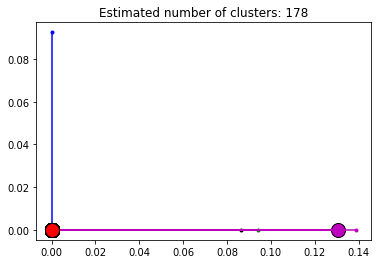

In [20]:
visualize_clustering_result(tdidf_ap_clustering_stopwords, tfidf_corpus_stopwords)

In [21]:
clusters = print_and_get_clusters(tdidf_ap_clustering_stopwords, corpus_stopwords)

Top terms per cluster:
Cluster 0:
('preference', 'pairwise', 'mallow', 'problem', 'aggregation', 'label', 'classification', 'supervised', 'query', 'result')


Cluster 1:
('selective', 'setting', 'stream', 'classification', 'label', 'active', 'pool', 'classifier', 'based', 'rejection')


Cluster 2:
('metric', 'kernel', 'performance', 'distance', 'ground', 'set', 'matrix', 'graph', 'eigenvalue', 'feature')


Cluster 3:
('selection', 'criterion', 'dimension', 'information', 'distribution', 'value', 'feature', 'machine', 'support', 'vector')


Cluster 4:
('factor', 'dantzig', 'selector', 'signal', 'proposed', 'log', 'number', 'solution', 'vector', 'sparse')


Cluster 5:
('task', 'transfer', 'problem', 'text', 'framework', 'reinforcement', 'skill', 'curriculum', 'agent', 'related')


Cluster 6:
('maximum', 'dimensionality', 'reduction', 'likelihood', 'analysis', 'linear', 'unfolding', 'approximate', 'dimensional', 'consistent')


Cluster 7:
('variational', 'approximation', 'gaussian', 'infe

('matrix', 'bound', 'error', 'approximation', 'prototype', 'column', 'selection', 'spsd', 'sampling', 'fast')


Cluster 67:
('mechanism', 'query', 'privacy', 'ontology', 'differential', 'learnability', 'result', 'classifier', 'utility', 'family')


Cluster 68:
('subspace', 'problem', 'recovery', 'sample', 'sdr', 'ms', 'dimension', 'sparse', 'condition', 'group')


Cluster 69:
('lasso', 'regression', 'sparse', 'group', 'approach', 'scheme', 'matrix', 'study', 'inversion', 'scaled')


Cluster 70:
('loss', 'boosting', 'class', 'regularization', 'fisher', 'problem', 'multi', 'function', 'sparse', 'training')


Cluster 71:
('framework', 'task', 'fast', 'stagewise', 'multitask', 'general', 'representation', 'component', 'feature', 'formulation')


Cluster 72:
('variable', 'selection', 'proposed', 'irrelevant', 'tuning', 'sparsity', 'parameter', 'gradient', 'relevant', 'show')


Cluster 73:
('ranking', 'comparison', 'item', 'problem', 'seriation', 'bound', 'pairwise', 'estimator', 'multilabel

('communication', 'distributed', 'function', 'optimization', 'framework', 'network', 'problem', 'decentralized', 'efficient', 'convex')


Cluster 147:
('change', 'point', 'system', 'graphical', 'penalty', 'surface', 'detection', 'regression', 'parameter', 'trajectory')


Cluster 148:
('gabp', 'convergence', 'definite', 'positive', 'gaussian', 'multivariate', 'node', 'extension', 'mg', 'regularization')


Cluster 149:
('function', 'coherence', 'ica', 'sparse', 'coding', 'overcomplete', 'hinge', 'linear', 'double', 'dictionary')


Cluster 150:
('convergence', 'sgd', 'stochastic', 'gradient', 'function', 'rate', 'problem', 'objective', 'descent', 'convex')


Cluster 151:
('reservoir', 'state', 'system', 'input', 'memory', 'time', 'space', 'oger', 'fading', 'filter')


Cluster 152:
('image', 'convolutional', 'invariance', 'network', 'information', 'representation', 'patch', 'neural', 'training', 'principle')


Cluster 153:
('constraint', 'problem', 'convex', 'time', 'optimization', 'regret

# Metrics

In [22]:
def calc_scores(corpus, model):
    return metrics.silhouette_score(corpus, model.labels_, metric='euclidean'), metrics.calinski_harabasz_score(corpus.toarray(), model.labels_), metrics.davies_bouldin_score(corpus.toarray(), model.labels_)

scores = []

score = list(calc_scores(tfidf_corpus, tdidf_ap_clustering))
score.insert(0, 'normal model')
scores.append(score)

score = list(calc_scores(tfidf_corpus_stopwords, tdidf_ap_clustering_stopwords))
score.insert(0, 'model with custom stopwords')
scores.append(score)


scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

                    model type  silhouette_score  calinski_harabasz_score  \
0                 normal model          0.030495                 2.134269   
1  model with custom stopwords          0.031234                 2.141206   

   davies_bouldin_score  
0              2.853512  
1              2.839059  


# Test with SpectralEmbedding

In [23]:
vectorizer_spec_embedding = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus_spec_embedding = vectorizer_spec_embedding.fit_transform(corpus["token"])
tfidf_corpus_spec_embedding_array = SpectralEmbedding(n_components=5).fit_transform(tfidf_corpus_spec_embedding.toarray())

In [25]:
tdidf_ap_clustering_spectral = AffinityPropagation(random_state=0)
tdidf_ap_clustering_spectral.fit(tfidf_corpus_spec_embedding_array)
pickle.dump(tdidf_ap_clustering_spectral, open('ap_data/tdidf_ap_clustering_spectral', 'wb'))

AffinityPropagation(random_state=0)

In [26]:
clusters = print_and_get_clusters(tdidf_ap_clustering_spectral, corpus)

Top terms per cluster:
Cluster 0:
('kernel', 'learning', 'data', 'classification', 'multi', 'class', 'vector', 'machine', 'classifier', 'algorithm')


Cluster 1:
('model', 'learning', 'data', 'task', 'bayesian', 'method', 'process', 'time', 'gaussian', 'approach')


Cluster 2:
('algorithm', 'method', 'data', 'problem', 'sampling', 'sample', 'dictionary', 'convex', 'based', 'result')


Cluster 3:
('model', 'algorithm', 'gaussian', 'data', 'method', 'sparse', 'graphical', 'variable', 'matrix', 'dimensional')


Cluster 4:
('algorithm', 'problem', 'method', 'convex', 'loss', 'regression', 'gradient', 'optimization', 'learning', 'descent')


Cluster 5:
('regression', 'estimation', 'density', 'lasso', 'estimator', 'model', 'distributed', 'data', 'method', 'high')


Cluster 6:
('python', 'learning', 'data', 'machine', 'framework', 'model', 'user', 'toolbox', 'source', 'graph')


Cluster 7:
('model', 'causal', 'variational', 'probabilistic', 'topic', 'pomegranate', 'inference', 'algorithm', 'p

Estimated number of clusters: 51


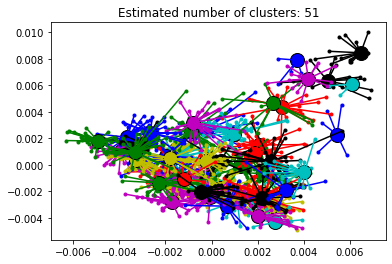

In [27]:
visualize_clustering_result_arr(tdidf_ap_clustering_spectral, tfidf_corpus_spec_embedding_array)

In [28]:
def calc_scores_arr(corpus, model):
    return metrics.silhouette_score(corpus, model.labels_, metric='euclidean'), metrics.calinski_harabasz_score(corpus, model.labels_), metrics.davies_bouldin_score(corpus, model.labels_)

scores = []

score = list(calc_scores_arr(tfidf_corpus_spec_embedding_array, tdidf_ap_clustering_spectral))
score.insert(0, 'model with spectral embedding')
scores.append(score)


scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

                      model type  silhouette_score  calinski_harabasz_score  \
0  model with spectral embedding          0.188029               199.463342   

   davies_bouldin_score  
0               1.30149  


# Test with LSA

In [29]:
def get_lsa_transformation(n_components, corpus):
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    return lsa.fit_transform(corpus),svd

In [32]:
n_components = 5
X, svd = get_lsa_transformation(n_components, tfidf_corpus)

tdidf_ap_clustering_lsa = AffinityPropagation(random_state=0)
tdidf_ap_clustering_lsa.fit(X)
pickle.dump(tdidf_ap_clustering_lsa, open('ap_data/tdidf_ap_clustering_lsa', 'wb'))

AffinityPropagation(random_state=0)

In [33]:
clusters = print_and_get_clusters(tdidf_ap_clustering_lsa, corpus)

Top terms per cluster:
Cluster 0:
('model', 'data', 'feature', 'task', 'approach', 'image', 'latent', 'learning', 'gaussian', 'set')


Cluster 1:
('model', 'selection', 'estimator', 'variable', 'gaussian', 'regression', 'estimation', 'high', 'graphical', 'tensor')


Cluster 2:
('learning', 'machine', 'task', 'label', 'algorithm', 'meta', 'agent', 'multi', 'system', 'framework')


Cluster 3:
('algorithm', 'method', 'data', 'problem', 'optimal', 'sample', 'learning', 'bound', 'linear', 'function')


Cluster 4:
('model', 'network', 'causal', 'neural', 'inference', 'topic', 'learning', 'prediction', 'algorithm', 'data')


Cluster 5:
('learning', 'algorithm', 'label', 'active', 'manifold', 'toolbox', 'optimization', 'using', 'setting', 'regret')


Cluster 6:
('tensor', 'graph', 'machine', 'data', 'factorization', 'annotator', 'tensorly', 'source', 'clustering', 'ensemble')


Cluster 7:
('algorithm', 'convex', 'convergence', 'regression', 'gradient', 'problem', 'method', 'bound', 'risk', 'ra

Estimated number of clusters: 53


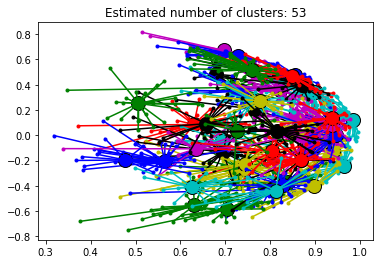

In [34]:
visualize_clustering_result_arr(tdidf_ap_clustering_lsa, X)

In [35]:
scores = []

score = list(calc_scores_arr(X, tdidf_ap_clustering_lsa))
score.insert(0, 'model with lsa embedding')
scores.append(score)


scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

                 model type  silhouette_score  calinski_harabasz_score  \
0  model with lsa embedding          0.193265               180.728882   

   davies_bouldin_score  
0               1.26669  


# Jessis plotting method

In [36]:
def plot(model, corpus, input_dense=False):
    random_state = 1
    #centroids = model.cluster_centers_

    tsne_init = 'pca'  # could also be 'random'
    tsne_perplexity = 20.0
    tsne_early_exaggeration = 4.0
    tsne_learning_rate = 10
    tsne = TSNE(n_components=2, random_state=random_state, init=tsne_init,
        perplexity=tsne_perplexity,
        early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)
    
    if input_dense:
        transformed = tsne.fit_transform(corpus)
    else:
        transformed = tsne.fit_transform(corpus.todense())
    plt.scatter(transformed[:, 0], transformed[:, 1], c=model.labels_, marker='x')
    plt.show()

## Normal

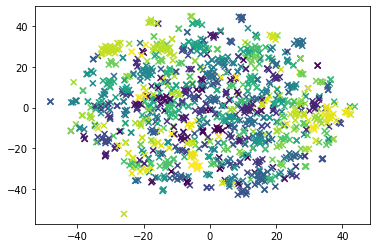

In [37]:
plot(tdidf_ap_clustering, tfidf_corpus)

## Spectral

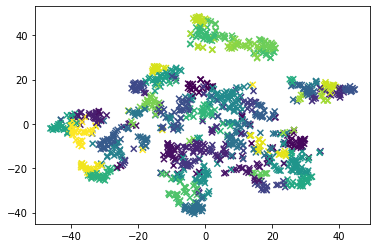

In [38]:
plot(tdidf_ap_clustering_spectral, tfidf_corpus_spec_embedding_array, True)

## LSA

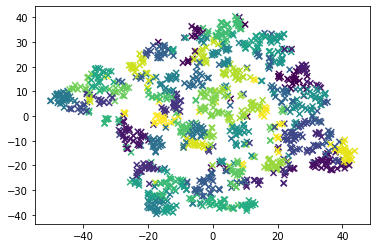

In [39]:
plot(tdidf_ap_clustering_lsa, X, True)